# Run Data Assimilation 

In this notebook, we will run the data assimilation (DA) that will get us from data to reconstruction. The goal is to use _cfr_'s codebase with no edits to reproduce LMRv2.1 by [Tardif et al. 2019](https://cp.copernicus.org/articles/15/1251/2019/). 

## Author
[Tanaya Gondhalekar](https://orcid.org/0009-0004-2440-3266)


⚠️ **Warning** 

 This notebook cannot be run locally! The process is run on USC's Center for Advanced Research Computing (CARC) HPC Servers. The specifications used will be provided in the shell file below.

### shell file for CARC

```bash
#!/bin/bash

#SBATCH --partition=main
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=32G
#SBATCH --time=40:00:00

module purge
eval "$(conda shell.bash hook)"

conda activate cfr-env

python lmr_reproduce.py
```


In [35]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
print(cfr.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2025.5.7


## Load Data
The data needed to run this reconstruction comes in three parts:\
- Prior: Model output climate data (CMIP5 CCSM4)\
- Calibration: Instrumental climate data (temperature: GISTEMPv4, precipitation: GPCCv6)\
- Proxy: Proxy data (from PAGES2k)

1. Download from [here](http://www.atmos.uw.edu/~wperkins/nobackup/lmr_data/LMR_data.tar.gz)
2. Extract all relevant contents into ./prev_data/
3. **Prior** data can be found under LMR_data > data > model > ccsm4_last_millenium\
    a. Put in directory ./prev_data/ccsm4_last_millenium/ \
    b. Required:
    - pr_sfc_Amon_CCSM4_past1000_085001-185012.nc
    - tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
6. **Calibration** data can be found under LMR_data > data > analyses copy > GPCC
    - The other calibration dataset (GISTEMPv4) comes shipped with _cfr_, but GPCCv6 does not. 
7. **Proxy** data ([PAGES2kv2](https://pastglobalchanges.org/science/wg/2k-network/Phase_2_Databases/Global_Temp/V2.0.0_2017)) will come from ~Notebook 01~. 

### Load proxies

This comes from ~Notebook 01~, where the data is accessed through the LipDGraph and processed to fit the format of _cfr_'s ```ProxyDatabase``` Class.\
\
```load_proxydb()``` takes in a .json, .pckl, or .nc file and with the given columns, very specific to _cfr_, creates a new ```ProxyDatabase``` object for our use in the reconstruction. In this specific example, we will use a NetCDF file created by ~Notebook 01.x~. 

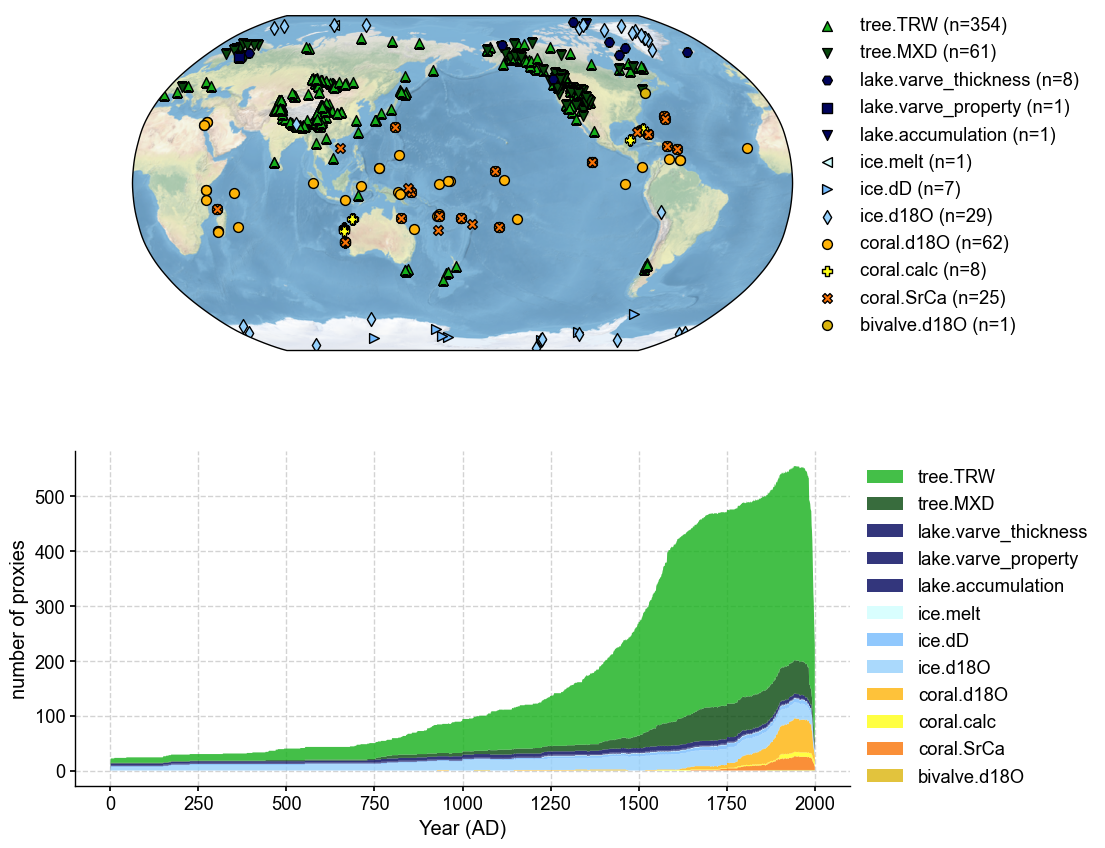

In [37]:
# new

pdb = cfr.ProxyDatabase().load_nc('./prev_data/filtered_ptype_res_cfr_pages2kv2.nc')
pdb.refresh()

job = cfr.ReconJob()
job.proxydb = pdb

#job.filter_proxydb(by='ptype', keys=['coral', 'tree', 'bivalve', 'ice', 'lake.varve_thickness', 'lake.varve_property', 'lake.accumulation'])

fig, ax = job.proxydb.plot(plot_count=True)

### Load model prior 

This reconstruction uses [CMIP5 CCSM4 past 1000](https://www.wdc-climate.de/WDCC/CMIP5/Compact.jsp?acronym=NRS4pk) as the model prior. This is the Coupled Model Intercomparison Project phase 5 (CMIP5) (Taylor et al., 2012) Last Millennium simulation from the Community Climate System Model version 4 (CCSM4) coupled atmosphere–ocean–sea-ice model. The simulation covers years 850 to 1850 CE and includes incoming solar variability and variable greenhouse gases, as well as stratospheric aerosols from volcanic eruptions known to have occurred during the simulation period (Tardif et al., 2019). This model prior provides the initial climate states used in the data assimilation (DA) step.\
\
```load_clim()``` loads in .nc files (or files that are shipped with the package) and formats them into ```ClimateField``` objects for use in the DA workflow.\
\
```anom_period``` refers to the climatological reference period with which to compute climate anomalies. Tardif et al. use the full interval for LMRv2.1.

In [ ]:
job.load_clim(
    tag='prior',
    
    path_dict= {
    'tas': './prev_data/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
    'pr': './prev_data/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'
    },
    anom_period=[850,1850],  # Tardif 2019 uses entire interval
    load=True,  
    verbose=True,
)

Do a check in after loading to make sure the NetCDF file loaded in correctly. If there are any ```NaN``` values, you will be warned.

In [ ]:
# Check after load
print("\nAfter initial load:")
print("Shape:", job.prior['tas'].da.shape)
print("Contains NaN?", np.any(np.isnan(job.prior['tas'].da.values)))
if not np.any(np.isnan(job.prior['tas'].da.values)):
    print("Sample values from first timestep:")
    vals = job.prior['tas'].da.isel(time=0, lat=slice(0,5), lon=slice(0,5)).values
    print(vals)

### Load calibration data

The calibration data sets used in this study are the NASA Goddard Institute for Space Studies (GISS) Surface Temperature Analysis ([GISTEMP](https://data.giss.nasa.gov/gistemp/news/2010summer/)) (Hansen et al., 2010) version 4 for temperature and the gridded precipitation data set from the Global Precipitation Climatology Centre ([GPCC](https://psl.noaa.gov/data/gridded/data.gpcc.html)) (Schneider et al., 2014) version 6 as the source of monthly information on moisture input over land surfaces (Tardif et al., 2019).\
\
```anom_period``` is restricted exclusively to the instrumental period due to observational data constraints. 

In [ ]:
job.load_clim(
    tag='obs',
    path_dict={
        'pr': './prev_data/GPCC_precip.mon.flux.1x1.v6.nc',
        'tas': 'gistemp1200_ERSSTv4'
    },
    rename_dict={'pr': 'precip','tas': 'tempanomaly'},
    anom_period=[1951, 1980], 
    load=True,
    verbose = True
)

## Calibrate PSMs

PSM Calibration is a crucial step in the DA process because it defines a quantitative relationship between our observational data and the climate. Since proxies don't directly record climate variables (e.g.,temperature, precipitation), PSM calibration translates the climate variable from instrumental measurements into proxy variables (e.g., d18O, Mg/Ca). This makes sure that the proxy information is on the same scale as the prior climate state, allowing the DA algorithm to correctly weight and blend proxy data with model output. Without proper calibration, we risk introducing biases or inconsistencies between proxies and the prior, which can add error to the reconstruction. \
\
The first step is to create a dictionary between the proxy archive type and the type of calibration equation used. For most in LMRv2.1, they are linear univariate, with the exception being Tree Ring Width (TRW) which is bilinear, with temperature and precipitation used as inputs.
_Ref: Equation (7) and Equation (8)_ \
\
Next we specify a dictionary for seasonal growth. This defines the optimal growth periods in which the proxy archive experiences the fastest or most efficient growth in a caledar year. All possible growth seasons are checked and the optimal one is selected during the calibration step to maximize correlation with the climate variable. 



In [ ]:
# PSM to be used
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
    'tree.MXD': 'Linear',
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'ice.d18O': 'Linear',
    'ice.dD': 'Linear',
    'lake.varve_thickness': 'Linear',
}

# target variables
ptype_clim_dict = {
    'tree.TRW': ['tas', 'pr'],
    'tree.MXD': ['tas'],
    'coral.d18O': ['tas'],
    'coral.SrCa': ['tas'],
    'ice.d18O': ['tas'],
    'ice.dD': ['tas'],
    'lake.varve_thickness': ['tas'],
}

# Seasonality for each proxy type
ptype_season_dict = {
    'tree.TRW': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'tree.MXD': [  # expert curated pool of possible growing seasons
        #[1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'coral.d18O': list(range(1, 13)),            # annual
    'coral.SrCa': list(range(1, 13)),            # annual
    'ice.d18O': list(range(1, 13)),              # annual
    'ice.dD': list(range(1,13)),
    'lake.varve_thickness': list(range(1, 13)),  # annual
}

```calib_psms``` does what was described above. It takes in the observational proxy data and calibrates it using instrumental climate data to get a best fit regression.

In [ ]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    ptype_clim_dict=ptype_clim_dict,
    nobs_lb = 25,
    verbose=True,
)

### Run PSMs

```forward_psms``` runs the forward model (the PSM) with the prior as inputs and returns model-derived pseudoproxies as an output to be used in the DA solver. _Ref: Equation (2)_

In [ ]:
job.forward_psms(verbose=True)

### Annualize and Regrid model prior fields

In [ ]:

job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)

### (Optional) Save the job object for later reload

In [ ]:
job.save('./cases/lmr_reproduce_pda', verbose=True)

## Run DA solver

The DA solver used in LMRv2.1 (and _cfr_) is the Kalman Filter. In simple terms, the Kalman filter uses the innovation (difference between observed proxy data and forward model-derived pseudoproxy values) to adjust the model's estimate.  The amount of adjustment depends on the relative uncertainties in the proxies and the model. The Kalman filter gives more weight to whichever source (proxy or climate) has a smaller error, resulting in an updated estimate of the climate state at each time step. _Ref: Equation (3)_ \
\
We run 51 Monte Carlo (MC) iterations with 100 ensemble members each. This gives us 5100 realizations of past climate states. _Ref: Equation (1)_

In [ ]:
job.run_da_mc(
    save_dirpath='./recons/lmr_reproduce_pda',
    recon_seeds=list(range(1, 2)),  # as an example here
    recon_vars=['tas','pr'],  # running tas and pr even though paper mainly focuses on tas
    recon_period=[1, 2000],
    verbose=True,
)

In [ ]:
res = cfr.ReconRes('./recons/lmr_reproduce_pda/')

## Figure checks

After running the full DA workflow, we want to make sure the reconstructions actually exist, so let's do a quick check to confirm that we get both a climate field and an ensemble time series for the ```'tas'``` and ```'pr'``` variables.

In [ ]:
res.load(['tas', 'tas_gm', 'pr', 'pr_gm'])

# Create a basic plot
if 'tas' in res.recons:
    fig, ax = res.recons['tas'].plot(cmap='bwr')

In [ ]:
# Plot with ensemble spread
fig, ax = res.recons['tas_gm'].plot_qs()

In [ ]:
fig, ax = res.recons['pr'].plot()

In [ ]:
fig, ax = res.recons['pr_gm'].plot_qs()